Acceptance rate: 0.6419


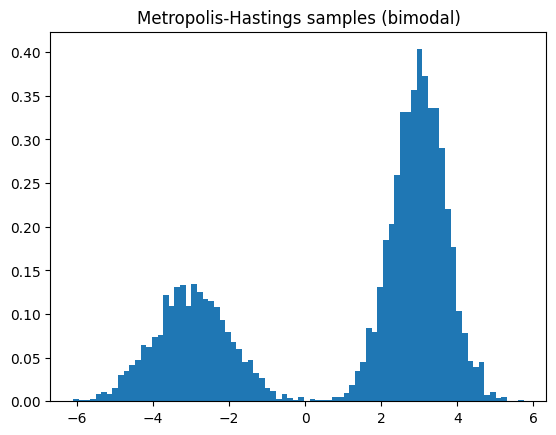

In [ ]:
import numpy as np

def metropolis_hastings(log_target, q_sample, q_logpdf=None, x0=0.0, n_samples=10000, burn_in=1000, thin=1, rng=None):
    """
    Generic Metropolis-Hastings sampler.
    - log_target(x): returns log of unnormalized target density at x (supports numpy arrays if desired).
    - q_sample(x): propose new sample given current x (returns proposed x').
    - q_logpdf(x_new, x_old): (optional) log proposal density log q(x_new | x_old). If None, assumes symmetric proposal and cancels.
    - x0: initial state (scalar or array).
    - returns samples after burn-in and thinning as numpy array of shape (n_kept, ...).
    """
    rng = np.random.default_rng() if rng is None else rng
    x = np.array(x0, copy=True)
    dims = x.shape if hasattr(x, 'shape') else ()
    samples = []
    n_accept = 0

    logp_x = log_target(x)

    for i in range(n_samples):
        x_proposed = q_sample(x)
        logp_prop = log_target(x_proposed)

        log_alpha = logp_prop - logp_x
        if q_logpdf is not None:
            log_alpha += q_logpdf(x, x_proposed) - q_logpdf(x_proposed, x)

        if np.log(rng.random()) < log_alpha:
            x = x_proposed
            logp_x = logp_prop
            n_accept += 1

        if i >= burn_in and ((i - burn_in) % thin == 0):
            samples.append(np.array(x, copy=True))

    samples = np.stack(samples, axis=0)
    acc_rate = n_accept / n_samples
    return samples, acc_rate

# Example: sample from 1D bimodal mixture p(x) = 0.3*N(-3,1) + 0.7*N(3,0.5)
if __name__ == "__main__":
    import matplotlib.pyplot as plt
    def log_target(x):
        # x may be scalar or array
        x = np.atleast_1d(x)
        logdens = np.log(0.3 * (1/np.sqrt(2*np.pi))*np.exp(-0.5*(x+3)**2) +
                         0.7 * (1/np.sqrt(2*np.pi*0.5))*np.exp(-0.5*(x-3)**2/0.5))
        return logdens if x.shape != () else logdens[0]

    rng = np.random.default_rng(1)
    # Gaussian random-walk proposal
    def q_sample(x): return x + rng.normal(scale=1.0, size=np.shape(x))

    samples, acc = metropolis_hastings(log_target, q_sample, x0=0.0, n_samples=30000, burn_in=5000, thin=5, rng=rng)
    print("Acceptance rate:", acc)
    plt.hist(samples.ravel(), bins=80, density=True)
    plt.title("Metropolis-Hastings samples (bimodal)")
    plt.show()

Acceptance rate: 0.6419


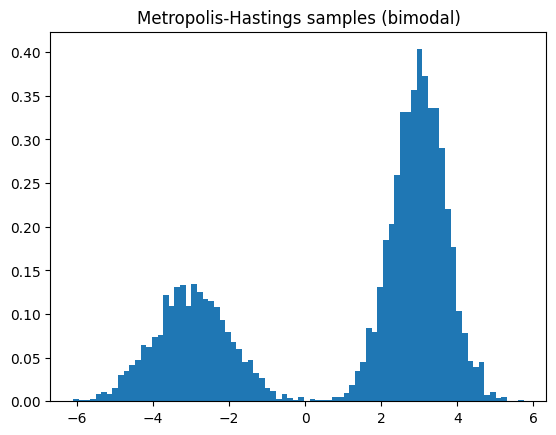

In [ ]:
import numpy as np

def metropolis_hastings(log_target, q_sample, q_logpdf=None, x0=0.0, n_samples=10000, burn_in=1000, thin=1, rng=None):
    """
    Generic Metropolis-Hastings sampler.
    - log_target(x): returns log of unnormalized target density at x (supports numpy arrays if desired).
    - q_sample(x): propose new sample given current x (returns proposed x').
    - q_logpdf(x_new, x_old): (optional) log proposal density log q(x_new | x_old). If None, assumes symmetric proposal and cancels.
    - x0: initial state (scalar or array).
    - returns samples after burn-in and thinning as numpy array of shape (n_kept, ...).
    """
    rng = np.random.default_rng() if rng is None else rng
    x = np.array(x0, copy=True)
    dims = x.shape if hasattr(x, 'shape') else ()
    samples = []
    n_accept = 0

    logp_x = log_target(x)

    for i in range(n_samples):
        x_proposed = q_sample(x)
        logp_prop = log_target(x_proposed)

        log_alpha = logp_prop - logp_x
        if q_logpdf is not None:
            log_alpha += q_logpdf(x, x_proposed) - q_logpdf(x_proposed, x)

        if np.log(rng.random()) < log_alpha:
            x = x_proposed
            logp_x = logp_prop
            n_accept += 1

        if i >= burn_in and ((i - burn_in) % thin == 0):
            samples.append(np.array(x, copy=True))

    samples = np.stack(samples, axis=0)
    acc_rate = n_accept / n_samples
    return samples, acc_rate

# Example: sample from 1D bimodal mixture p(x) = 0.3*N(-3,1) + 0.7*N(3,0.5)
if __name__ == "__main__":
    import matplotlib.pyplot as plt
    def log_target(x):
        # x may be scalar or array
        x = np.atleast_1d(x)
        logdens = np.log(0.3 * (1/np.sqrt(2*np.pi))*np.exp(-0.5*(x+3)**2) +
                         0.7 * (1/np.sqrt(2*np.pi*0.5))*np.exp(-0.5*(x-3)**2/0.5))
        return logdens if x.shape != () else logdens[0]

    rng = np.random.default_rng(1)
    # Gaussian random-walk proposal
    def q_sample(x): return x + rng.normal(scale=1.0, size=np.shape(x))

    samples, acc = metropolis_hastings(log_target, q_sample, x0=0.0, n_samples=30000, burn_in=5000, thin=5, rng=rng)
    print("Acceptance rate:", acc)
    plt.hist(samples.ravel(), bins=80, density=True)
    plt.title("Metropolis-Hastings samples (bimodal)")
    plt.show()


In [ ]:
import numpy as np

def hmc(log_prob, grad_log_prob, step_size=0.1, n_steps=10, x0=None, n_samples=1000, burn_in=100, rng=None):
    """
    Simple HMC for continuous targets.
    - log_prob(x): returns log p(x) (scalar)
    - grad_log_prob(x): returns gradient of log p at x (numpy array)
    - step_size: epsilon
    - n_steps: L (leapfrog steps)
    """
    rng = np.random.default_rng() if rng is None else rng
    x = np.array(x0, dtype=float)
    samples = []
    accept = 0
    for i in range(n_samples):
        # Sample momentum
        p = rng.normal(size=x.shape)
        current_x = x.copy()
        current_p = p.copy()

        # half step for p
        p = p + 0.5 * step_size * grad_log_prob(x)

        # full leapfrog steps
        for _ in range(n_steps):
            x = x + step_size * p
            # full step for p except at end
            if _ != n_steps - 1:
                p = p + step_size * grad_log_prob(x)

        # final half-step
        p = p + 0.5 * step_size * grad_log_prob(x)
        # negate momentum for symmetry
        p = -p

        # Metropolis accept/reject
        current_H = -log_prob(current_x) + 0.5 * np.sum(current_p**2)
        proposed_H = -log_prob(x) + 0.5 * np.sum(p**2)
        if np.log(rng.random()) < (current_H - proposed_H):
            # accept (x already updated)
            accept += 1
        else:
            # reject: revert
            x = current_x

        if i >= burn_in:
            samples.append(x.copy())

    return np.array(samples), accept / n_samples

# Example: sample from 2D standard normal
if __name__ == "__main__":
    def log_p(x):
        return -0.5 * np.dot(x, x)

    def grad_log_p(x):
        return -x

    x0 = np.array([2.0, 0.0])
    samples, acc = hmc(log_p, grad_log_p, step_size=0.2, n_steps=25, x0=x0, n_samples=2000, burn_in=200)
    print("HMC acceptance rate:", acc)
    print("Sample mean:", samples.mean(axis=0))


HMC acceptance rate: 0.9945
Sample mean: [0.02408059 0.0270669 ]


In [1]:
import numpy as np

class SGLD:
    def __init__(self, loglik_grad, x, y, dim, lr=1e-3, prior_var=1.0, rng=None):
        """
        loglik_grad: function(w, minibatch_x, minibatch_y) -> gradient of log-likelihood wrt w
        x, y: full dataset
        dim: number of parameters
        lr: learning rate (step size)
        prior_var: Gaussian prior variance for weights
        """
        self.loglik_grad = loglik_grad
        self.x, self.y = x, y
        self.dim = dim
        self.lr = lr
        self.prior_var = prior_var
        self.rng = np.random.default_rng() if rng is None else rng

    def sample(self, n_samples=1000, batch_size=128, burn_in=200):
        w = np.zeros(self.dim)
        samples = []
        N = len(self.y)

        for it in range(n_samples + burn_in):
            idx = self.rng.choice(N, batch_size, replace=False)
            xb, yb = self.x[idx], self.y[idx]

            # gradient of log posterior = loglik + log prior
            grad_loglik = self.loglik_grad(w, xb, yb) * (N / batch_size)
            grad_prior = -(1 / self.prior_var) * w
            grad = grad_loglik + grad_prior

            # Langevin update with injected noise
            noise = self.rng.normal(scale=np.sqrt(self.lr), size=self.dim)
            w = w + 0.5 * self.lr * grad + noise

            if it >= burn_in:
                samples.append(w.copy())

        return np.array(samples)

if __name__ == "__main__":
    rng = np.random.default_rng(42)
    N, d = 2000, 500   # samples x dimensions
    X = rng.normal(size=(N, d))
    true_w = rng.normal(scale=0.1, size=d)
    logits = X @ true_w
    y = rng.binomial(1, 1/(1+np.exp(-logits)))

    # gradient of log-likelihood wrt w
    def loglik_grad(w, xb, yb):
        preds = 1/(1+np.exp(-(xb @ w)))
        return xb.T @ (yb - preds)

    sgld = SGLD(loglik_grad, X, y, dim=d, lr=1e-4, prior_var=1.0, rng=rng)
    samples = sgld.sample(n_samples=2000, burn_in=500)

    print("Posterior mean norm:", np.linalg.norm(samples.mean(axis=0)))
    print("Posterior covariance (diag, first 5):", np.var(samples, axis=0)[:5])


Posterior mean norm: 5.59729542565969
Posterior covariance (diag, first 5): [0.00577869 0.01074917 0.01752552 0.00744145 0.00924076]
